In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Reading dataset

In [2]:
exp = 'mw'
name = 'moscow'

In [3]:
dataset = pd.read_csv("../{}/{}_intensities.csv".format(exp, name))
cols = list(dataset.columns)
cols[0] = 'sample_name'
dataset.columns = cols
dataset = dataset.set_index('sample_name')
dataset = dataset.loc[dataset.apply(lambda x: np.logical_not(np.all(np.isnan(x))), axis=1) ,
                      dataset.apply(lambda x: np.logical_not(np.all(np.isnan(x))), axis=0)]

idx_samples = np.array([x for x in dataset.index if not 'EQC' in x and not 'blank' in x])
idx_blanks  = np.array([x for x in dataset.index if 'blank' in x])
idx_eqc     = np.array([x for x in dataset.index if 'EQC' in x])
idx         = np.array(list(dataset.index))
cols        = np.array(dataset.columns)

dataset.index = pd.MultiIndex.from_tuples([('raw', x) for x in idx], names=['type', 'sample_index'])

In [4]:
metadata = pd.read_csv("../{}/{}_samples.csv".format(exp, name))
cols_meta = list(metadata.columns)
cols_meta[0] = 'sample_name'
metadata.columns = cols_meta
metadata = metadata.set_index('sample_name')

In [5]:
#query = dataset.loc['raw', :, :]

### Dataset visualization

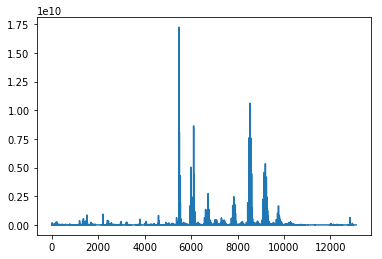

In [6]:
plt.plot(np.nanmean( dataset.loc['raw', :, :].values, axis=0 ))

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


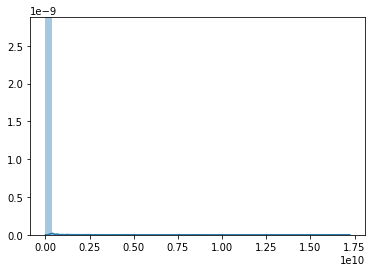

In [9]:
toplot = np.nanmean( dataset.loc['raw', :, :].values, axis=0 )
sns.distplot( toplot[np.isfinite(toplot)] )

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


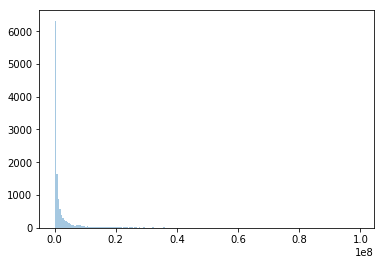

In [10]:
sns.distplot( toplot[np.isfinite(toplot)], bins=np.arange(0, 1e8, 5e5), kde=False )

### Dataset log-transformation

In [11]:
dataset.shape, len(idx), len(cols)

((423, 13112), 423, 13112)

In [12]:
dataset = pd.concat( [dataset, 
            pd.DataFrame( np.log(dataset.loc['raw', idx, :].values), 
             index   = pd.MultiIndex.from_tuples([('log', x) for x in idx], names=['type', 'sample_index']),
             columns = cols)
           ])

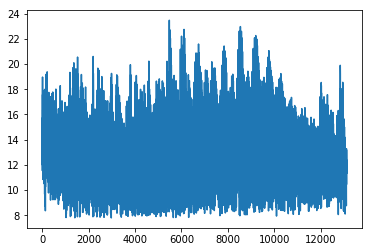

In [13]:
plt.plot(np.nanmean( dataset.loc['log', :, :].values, axis=0 ))

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


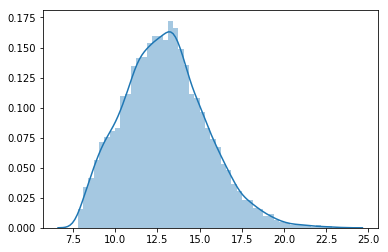

In [14]:
sns.distplot( np.nanmean( dataset.loc['log', :, :].values, axis=0 ) )

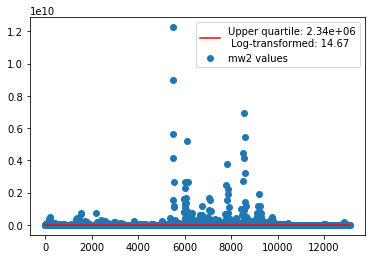

In [15]:
k = '{}2'.format(exp)
toplot = dataset.loc['raw', k, :].values[0]
plt.scatter(np.arange(len(toplot)), toplot, label='{} values'.format(k))
upper_quart = np.nanpercentile(toplot, 75)
plt.plot([0, len(toplot)], [upper_quart, upper_quart], color='red', 
         label='Upper quartile: {:.2e}\n Log-transformed: {:.2f}'.format(upper_quart, np.log(upper_quart)))
plt.legend()

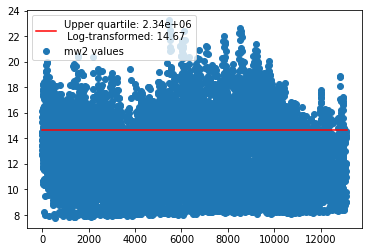

In [16]:
k = '{}2'.format(exp)
toplot = dataset.loc['log', k, :].values[0]
plt.scatter(np.arange(len(toplot)), toplot, label='{} values'.format(k))
upper_quart = np.nanpercentile(toplot, 75)
plt.plot([0, len(toplot)], [upper_quart, upper_quart], color='red', 
         label='Upper quartile: {:.2e}\n Log-transformed: {:.2f}'.format(np.exp(upper_quart), upper_quart))
plt.legend()


### Assessing technical biases

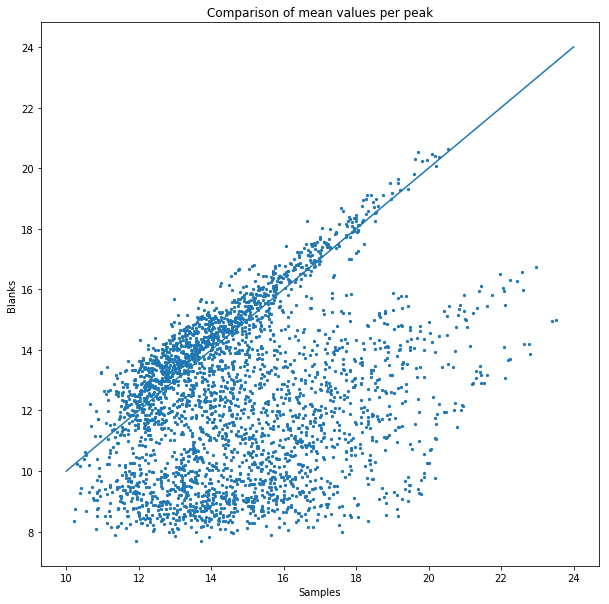

In [17]:
toplot = dataset.loc['log', :, :]

x = np.mean(toplot.loc[idx_samples,:].values, axis=0)
y = np.mean(toplot.loc[idx_blanks,:].values, axis=0)

plt.figure(figsize=[10,10])
plt.scatter(x, y, s=5)
plt.title('Comparison of mean values per peak')
plt.xlabel('Samples')
plt.ylabel('Blanks')

plt.plot([10,24], [10,24])

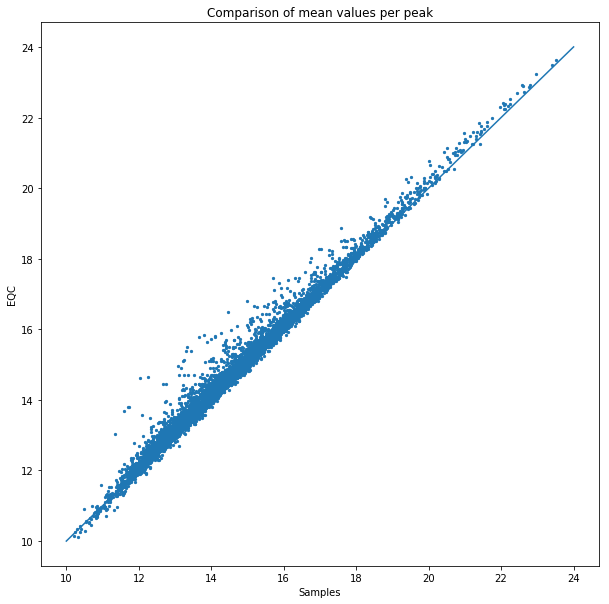

In [18]:
toplot = dataset.loc['log', :, :]

x = np.mean(toplot.loc[idx_samples,:].values, axis=0)
y = np.mean(toplot.loc[idx_eqc,:].values, axis=0)

plt.figure(figsize=[10,10])
plt.scatter(x, y, s=5)
plt.title('Comparison of mean values per peak')
plt.xlabel('Samples')
plt.ylabel('EQC')

plt.plot([10,24], [10,24])

In [19]:
# Let's calculate std

def get_distance_to_diagonal(x, y):
    p0 = np.array([x,y])
    p1 = np.array([0,0])
    p2 = np.array([25,25])
    return np.abs(np.cross(p2-p1, p1-p0)) / np.linalg.norm(p2-p1)

In [20]:
x = np.mean(toplot.loc[idx_samples,:].values, axis=0)
y = np.mean(toplot.loc[idx_eqc,:].values, axis=0)
std = np.nanstd([get_distance_to_diagonal(xi, yi) for xi, yi in zip(x, y)])

In [21]:
std

0.16577871855102286

In [22]:
x = np.mean(toplot.loc[idx_samples,:].values, axis=0)
y = np.mean(toplot.loc[idx_blanks,:].values, axis=0)

dists = np.array([get_distance_to_diagonal(xi, yi) for xi, yi in zip(x, y)])

mask_accepted = np.ones(len(x), dtype='S16')
mask_accepted[mask_accepted==b'1'] = 'good'

mask_accepted[(dists<3*std)] = 'blank_higher'

mask_accepted[(y>x)&(mask_accepted==b'good')] = '3std_eqc'

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


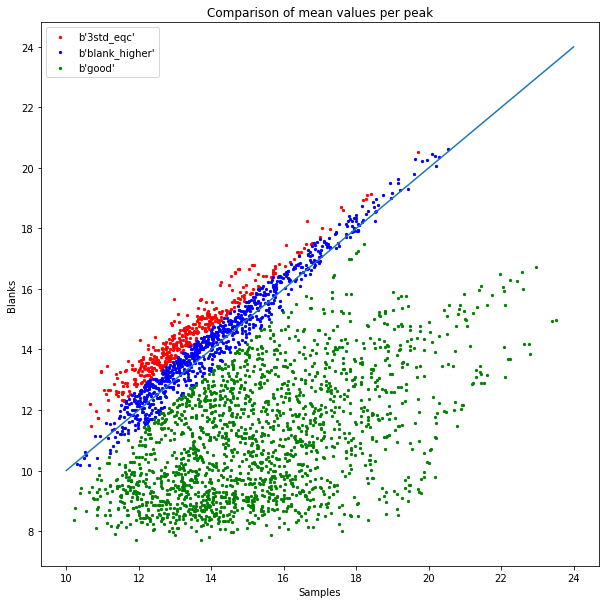

In [23]:
toplot = dataset.loc['log', :, :]
plt.figure(figsize=[10,10])
colors = ['r', 'b', 'g']
for c, v in zip(colors, np.unique(mask_accepted)):
    mask = mask_accepted==v
    plt.scatter(x[mask], y[mask], s=5, c=c, label=v)
    
plt.title('Comparison of mean values per peak')
plt.xlabel('Samples')
plt.ylabel('Blanks')

plt.plot([10,24], [10,24])
plt.legend()

In [24]:
filtering_stats = pd.DataFrame({x: [np.sum(mask_accepted==x)] for x in np.unique(mask_accepted)}, index=['raw_count']).T
filtering_stats.loc[:, 'prc_from_good']  = 100*filtering_stats.raw_count/filtering_stats.raw_count[b'good']
filtering_stats.loc[:, 'prc_from_total'] = 100*filtering_stats.raw_count/filtering_stats.raw_count.sum()

In [25]:
filtering_stats

,raw_count,prc_from_good,prc_from_total
b'3std_eqc',391,3.296796,2.982001
b'blank_higher',861,7.259696,6.566504
b'good',11860,100.000000,90.451495


In [26]:
cols_ContaminationFilterFailed = cols[mask_accepted!=b'good']

### NA quality control

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


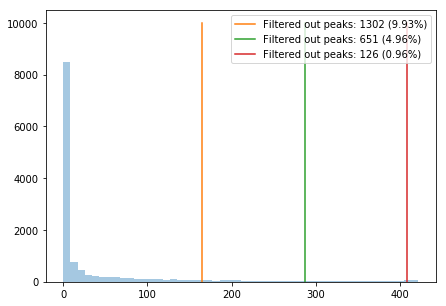

In [27]:
plt.figure(figsize=[7,5])

count_nan_per_peak = np.sum( np.isnan(dataset.loc['log', :, :].values ), axis=0)
sns.distplot(count_nan_per_peak, kde=False )
for score in [90, 95, 99]:
    toplot = np.percentile(count_nan_per_peak, score)
    plt.plot([toplot, toplot], [0,10000], 
             label="Filtered out peaks: {} ({:.2f}%)".format(
                 np.sum(count_nan_per_peak>toplot), 100*np.sum(count_nan_per_peak>toplot)/len(count_nan_per_peak)))
    
plt.legend(loc='upper right')

In [28]:
th_na_per_peak = np.percentile(count_nan_per_peak, 95)
cols_NAFilterFailed = cols[count_nan_per_peak>th_na_per_peak]

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


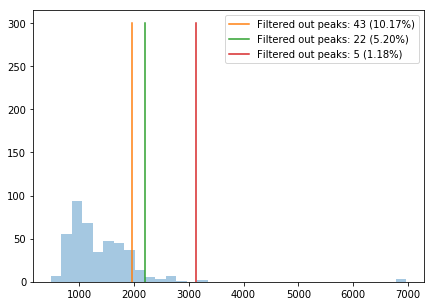

In [29]:
count_nan_per_sample = np.sum( np.isnan(dataset.loc['log', :, :].values ), axis=1)

plt.figure(figsize=[7,5])

sns.distplot(count_nan_per_sample, kde=False )
for score in [90, 95, 99]:
    toplot = np.percentile(count_nan_per_sample, score)
    plt.plot([toplot, toplot], [0,300], 
             label="Filtered out peaks: {} ({:.2f}%)".format(
                 np.sum(count_nan_per_sample>toplot), 100*np.sum(count_nan_per_sample>toplot)/len(count_nan_per_sample)))
    
plt.legend(loc='upper right')

In [30]:
th_na_per_sample = np.percentile(count_nan_per_sample, 99)
idx_NAFilterFailed = idx[count_nan_per_sample>th_na_per_sample]

### Sample outliers detection

/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


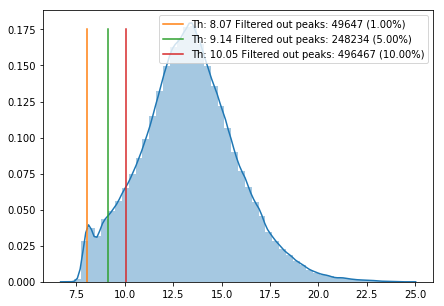

In [31]:
total = dataset.loc['log', :, :].values.flatten()
total = total[np.isfinite(total)]
plt.figure(figsize=[7,5])
sns.distplot(total)

for score in [1, 5, 10]:
    toplot = np.percentile(total, score)
    plt.plot([toplot, toplot], [0,0.175], 
             label="Th: {:.2f} Filtered out peaks: {} ({:.2f}%)".format(
                 toplot, np.sum(total<toplot), 100*np.sum(total<toplot)/len(total)))
    
plt.legend(loc='upper right')

In [32]:
toplot = dataset.loc['log', :, :].T.reset_index()#.T

In [33]:
tmp = []
for x in idx:
    df_tmp = toplot.loc[:,['index', x]].copy()
    df_tmp.columns = ['index', 'value']
    df_tmp.loc[:,'sample'] = x
    tmp.append(df_tmp.copy())
tmp = pd.concat( tmp )

In [34]:
vals = dataset.loc['log', idx_samples, :].apply(lambda x: np.sum(x<8.55), axis=1)
vals_sorted = vals.sort_values(ascending=False)

In [35]:
(dataset.loc['log', idx_samples, :]).shape

(356, 13112)

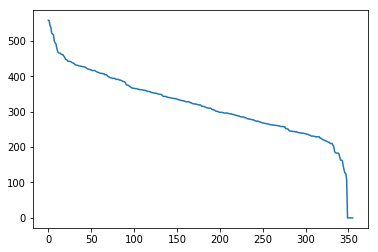

In [36]:
plt.plot( vals_sorted.values )

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

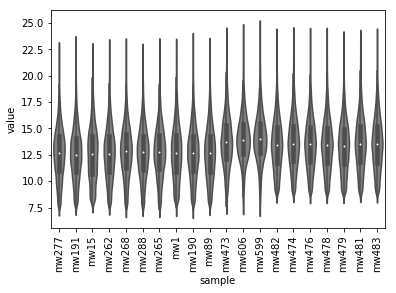

In [37]:
sns.violinplot(x="sample", y="value", data=tmp, order=np.concatenate([vals_sorted.loc['log', :].index[0:10], 
                                                                      vals_sorted.loc['log', :].index[-10:]]), color='grey')
plt.xticks(rotation=90)

In [38]:
### Yay! No need to filter out bad samples! They are all so-so good.

### Final filtering out and stats

In [39]:
# All filters present
#idx_NAFilterFailed, cols_ContaminationFilterFailed, cols_NAFilterFailed

In [40]:
len( np.intersect1d(cols_NAFilterFailed, cols_ContaminationFilterFailed) ) 

0

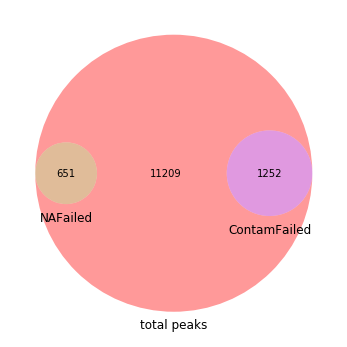

In [41]:
from matplotlib_venn import venn3

plt.figure(figsize=[6,6])

v1 = cols
v2 = cols_NAFilterFailed
v3 = cols_ContaminationFilterFailed

v2v3_j = np.concatenate( [v2, v3])
v1v2_j = np.concatenate( [v1, v2])
v1v3_j = np.concatenate( [v1, v3])

v1v2_i = np.intersect1d(v1, v2)
v2v3_i = np.intersect1d(v2, v3)
v1v3_i = np.intersect1d(v1, v3)

all_inter = np.intersect1d(v1v2_i, v3)

venn3(subsets = (
    len( np.setdiff1d(v1,  v2v3_j)), 
    len( np.setdiff1d(v2,  v1v3_j)), 
    len( np.setdiff1d(v1v2_i,  all_inter)), 
    len( np.setdiff1d(v3,  v2v3_j)), 
    len(np.setdiff1d(v1v3_i, all_inter)),
    len(np.setdiff1d(v2v3_i, all_inter)),
    len(all_inter)), set_labels=['total peaks', 'NAFailed', 'ContamFailed'])
plt.show()


/home/anaconda3/envs/distiller-editable/lib/python3.6/site-packages/matplotlib_venn/_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


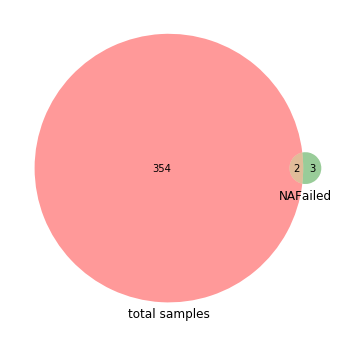

In [42]:
from matplotlib_venn import venn3

plt.figure(figsize=[6,6])

v1 = idx_samples
v2 = idx_NAFilterFailed
v3 = cols_ContaminationFilterFailed

v2v3_j = np.concatenate( [v2, v3])
v1v2_j = np.concatenate( [v1, v2])
v1v3_j = np.concatenate( [v1, v3])

v1v2_i = np.intersect1d(v1, v2)
v2v3_i = np.intersect1d(v2, v3)
v1v3_i = np.intersect1d(v1, v3)

all_inter = np.intersect1d(v1v2_i, v3)

venn3(subsets = (
    len( np.setdiff1d(v1,  v2v3_j)), 
    len( np.setdiff1d(v2,  v1v3_j)), 
    len( np.setdiff1d(v1v2_i,  all_inter)), 
    len( np.setdiff1d(v3,  v2v3_j)), 
    len(np.setdiff1d(v1v3_i, all_inter)),
    len(np.setdiff1d(v2v3_i, all_inter)),
    len(all_inter)), set_labels=['total samples', 'NAFailed', ''])
plt.show()


In [43]:
cols_good = np.setdiff1d( np.setdiff1d(cols,  cols_ContaminationFilterFailed), cols_NAFilterFailed )
idx_good  = np.setdiff1d( idx_samples,  idx_NAFilterFailed)

### Batch normalization

In [44]:
df_filtered = dataset.loc['log', idx_good, :].reset_index().set_index('sample_index').loc[:, cols_good]
#filling nas with min per feature
df_filtered = df_filtered.apply(lambda x: x.fillna( np.nanmin(x) ), axis=1)

df = metadata.join( df_filtered )
df = df.loc[idx_samples, :]

In [45]:
gr = df.groupby('batch_number').mean()

In [46]:
df_norm = df.apply( lambda x: x/gr.loc[x.batch_number, :] , axis=1).loc[idx_good, cols_good]

In [47]:
dataset_norm = df_norm.copy()
dataset_norm.index = pd.MultiIndex.from_tuples([('batch_norm', x) for x in idx_good], names=['type', 'sample_index'])

### Upper-quartile normalization

In [48]:
norm_coef = np.nanmean(np.nanpercentile(dataset_norm.loc['batch_norm', :, :].values, 75, axis=1))

dataset_norm = pd.concat( [dataset_norm, 
            pd.DataFrame( norm_coef*dataset_norm.loc['batch_norm', :, :].apply(
                lambda x: x/np.nanpercentile(x.values, 75), axis=1).values, 
             index   = pd.MultiIndex.from_tuples([('norm', x) for x in idx_good], names=['type', 'sample_index']),
             columns = cols_good)
           ])

Text(0.5,1,'Upper-quartile per sample')

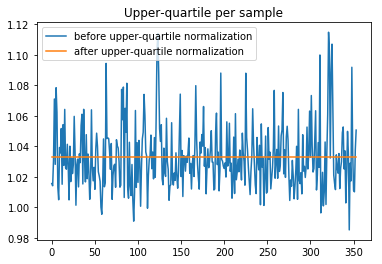

In [49]:
plt.plot(np.nanpercentile( dataset_norm.loc['batch_norm', :, :], 75, axis=1), label="before upper-quartile normalization" )
plt.plot(np.nanpercentile( dataset_norm.loc['norm', :, :], 75, axis=1), label="after upper-quartile normalization" )
plt.legend()
plt.title("Upper-quartile per sample")

Text(0.5,1,'Mean per sample')

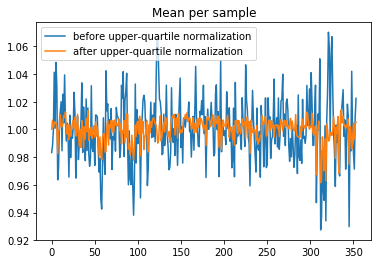

In [50]:
plt.plot(np.nanmean( dataset_norm.loc['batch_norm', :, :], axis=1), label="before upper-quartile normalization" )
plt.plot(np.nanmean( dataset_norm.loc['norm', :, :], axis=1),       label="after upper-quartile normalization" )
plt.legend()
plt.title("Mean per sample")

In [51]:
# Writing final datasets
dataset_norm.loc['norm', :, :].to_csv("../{}/normalized_dataset.csv".format(exp))

### PCA

In [52]:
from sklearn.decomposition import PCA

In [53]:
toplot = dataset_norm.loc['norm', :, :]

n_comp = 10

pca = PCA(n_components=n_comp)
principalComponents = pca.fit_transform(toplot)

principalDf = pd.DataFrame(data = principalComponents, 
                           columns = ['pc{}'.format(x+1) for x in range(n_comp)],
                          index = toplot.index)

finalDf = principalDf.reset_index().join(metadata.reset_index())

Text(0.5,1,'Variance explained')

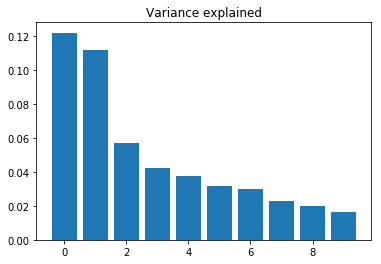

In [54]:
plt.bar(np.arange(n_comp), pca.explained_variance_ratio_)
plt.title('Variance explained')

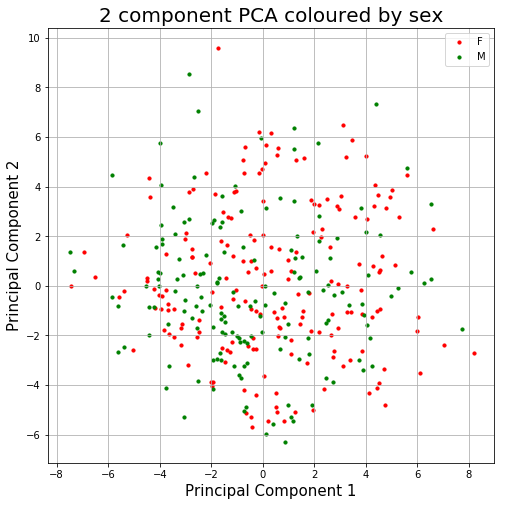

In [55]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA coloured by sex', fontsize = 20)
targets = ['F', 'M']
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['sex'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 10)
ax.legend(targets)
ax.grid()

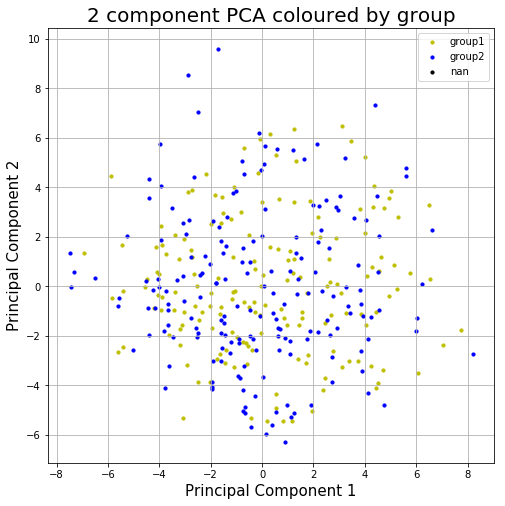

In [56]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA coloured by group', fontsize = 20)
targets = ['group1', 'group2', np.nan]
colors = ['y', 'b', 'black']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['diagnosis'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 10)
ax.legend(targets)
ax.grid()

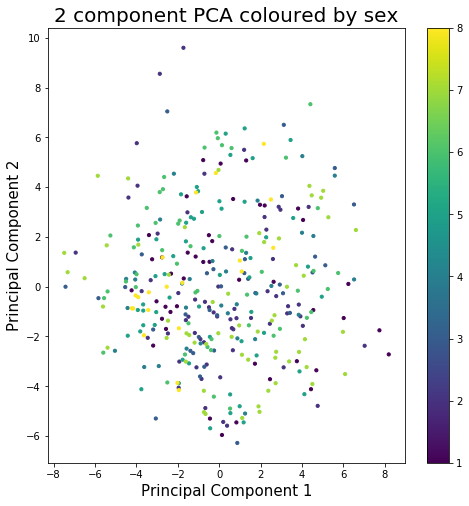

In [57]:
fig = plt.figure(figsize = (8,8))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 component PCA coloured by sex', fontsize = 20)

plt.scatter(finalDf.loc[:, 'pc1'], 
           finalDf.loc[:, 'pc2'], 
           c = finalDf.loc[:, 'batch_number'],
           s = 10)

plt.colorbar()

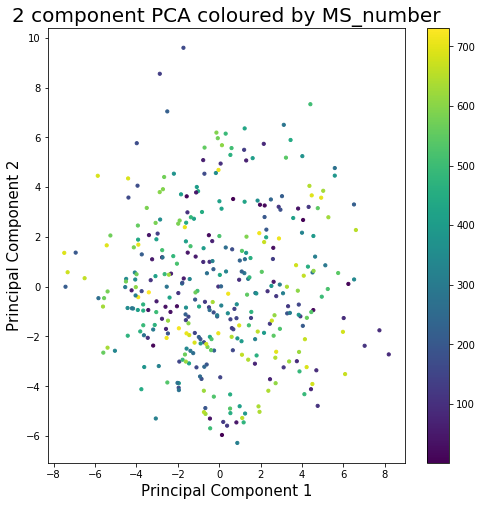

In [58]:
fig = plt.figure(figsize = (8,8))
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 component PCA coloured by MS_number', fontsize = 20)

plt.scatter(finalDf.loc[:, 'pc1'], 
           finalDf.loc[:, 'pc2'], 
           c = finalDf.loc[:, 'MS_number'],
           s = 10)

plt.colorbar()